# 7. Harris Edge & Corner Detection

## Table of Contents
1. [Libraries](#libraries)
2. [Color image to Grayscale conversion](#grayscale)
3. [Spatial derivative calculation](#spatial)
4. [Structure tensor setup](#tensor)
5. [Harris response calculation](#response)
6. [Find edges and corners using R](#find)
7. [Experimento](#experimento)
8. [Conclusión](#conclusion)

## 1. Importing Libraries <a class="anchor" id="libraries" ></a>

In [ ]:
import cv2
import matplotlib.pyplot as plt
from scipy import signal as sig
import numpy as np
from scipy.ndimage.filters import convolve

from google.colab import drive
import os

<ipython-input-36-1159a9c63d45>:5: DeprecationWarning: Please import `convolve` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.filters import convolve


In [ ]:
drive.mount('/content/drive')
DATA_PATH = '/content/drive/MyDrive/VISION COMPUTACIONAL'
os.chdir(DATA_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 2. Color to Grayscale <a class="anchor" id="grayscale" ></a>

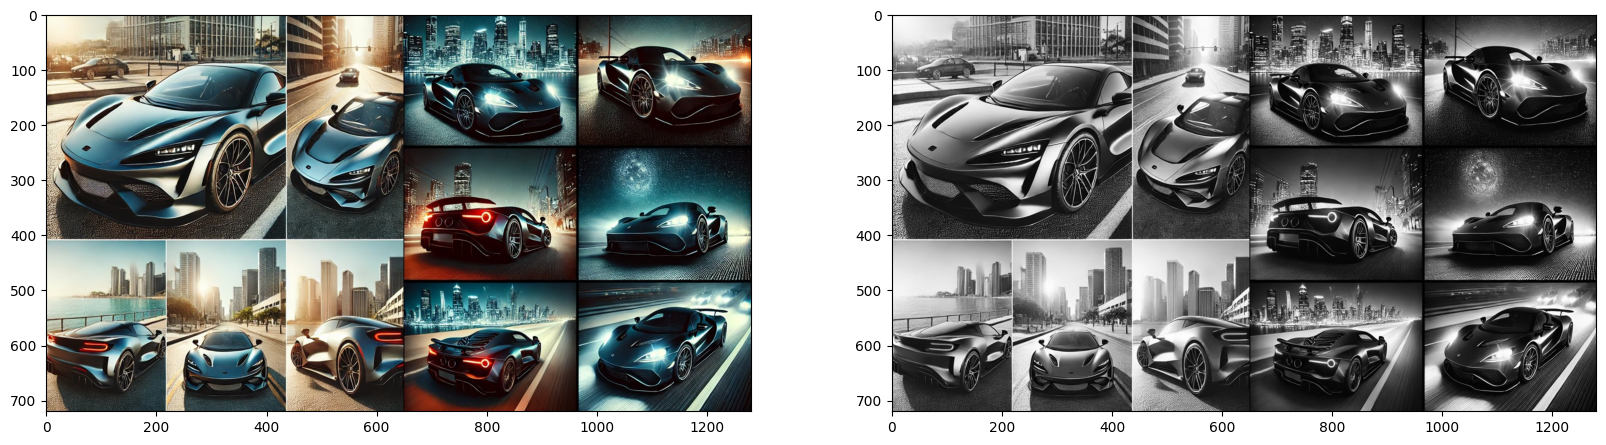

In [ ]:
img = cv2.imread('data/auto.JPG')
img_color = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_color)
plt.subplot(1, 2, 2)
plt.imshow(img_gray, cmap="gray")

## 3. Spatial derivative calculation <a class="anchor" id="spatial" ></a>

In [ ]:
def gradient_x(imggray):
    ##Sobel operator kernels.
    kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    return sig.convolve2d(imggray, kernel_x, mode='same')

def gradient_y(imggray):
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    return sig.convolve2d(imggray, kernel_y, mode='same')

I_x = gradient_x(img_gray)
I_y = gradient_y(img_gray)

## 4. Structure tensor setup <a class="anchor" id="tensor" ></a>

In [ ]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g


Ixx = convolve(I_x**2, gaussian_kernel(3, 1))
Ixy = convolve(I_y*I_x, gaussian_kernel(3, 1))
Iyy = convolve(I_y**2, gaussian_kernel(3, 1))

## 5. Harris response calculation <a class="anchor" id="response" ></a>

#### En esta sección decidimos modificar los ajustes predeterminados del algoritmo de detección de bordes y esquinas de Harris, el cual originalmente utiliza un solo valor de 𝑘 = 0.04 para el cálculo de la respuesta de esquina. Considerando que este valor podría no ser óptimo para todas las situaciones y para obtener resultados más ajustados a diferentes tipos de imágenes o escenarios, añadimos un arreglo con tres valores adicionales para el parámetro  𝑘.

#### Esto nos permite realizar pruebas con distintas configuraciones y mejorar la precisión en la detección de bordes y esquinas, optimizando así el rendimiento del algoritmo en distintos contextos. Esta modificación proporciona mayor flexibilidad y control sobre el proceso de detección.

In [ ]:
settings = [
    {"block_size": 2, "ksize": 3, "k": 0.04},
    {"block_size": 2, "ksize": 5, "k": 0.06},
    {"block_size": 3, "ksize": 3, "k": 0.04},
    {"block_size": 3, "ksize": 5, "k": 0.08},
]

# Aplicar Harris con cada configuración
for i, params in enumerate(settings):
    block_size = params["block_size"]
    ksize = params["ksize"]
    k = params["k"]

    # Calcular gradientes de la imagen
    Ixx = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=ksize) ** 2
    Iyy = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=ksize) ** 2
    Ixy = cv2.Sobel(img_gray, cv2.CV_64F, 1, 1, ksize=ksize) ** 2

    # Determinante y traza
    detA = Ixx * Iyy - Ixy ** 2
    traceA = Ixx + Iyy

    # Respuesta de Harris
    harris_response = detA - k * (traceA ** 2)

In [ ]:
img_gray.shape

(720, 1280)

In [ ]:
window_size = 3
offset = window_size//2
width, height = img_gray.shape

for y in range(offset, height-offset):
    for x in range(offset, width-offset):
        Sxx = np.sum(Ixx[y-offset:y+1+offset, x-offset:x+1+offset])
        Syy = np.sum(Iyy[y-offset:y+1+offset, x-offset:x+1+offset])
        Sxy = np.sum(Ixy[y-offset:y+1+offset, x-offset:x+1+offset])

In [ ]:
#Find determinant and trace, use to get corner response
det = (Sxx * Syy) - (Sxy**2)
trace = Sxx + Syy
r = det - k*(trace**2)

## 6. Find edges and corners using R <a class="anchor" id="find" ></a>

In [ ]:
img_copy_for_corners = np.copy(img)
img_copy_for_edges = np.copy(img)

for rowindex, response in enumerate(harris_response):
    for colindex, r in enumerate(response):
        if r > 0:
            # this is a corner
            img_copy_for_corners[rowindex, colindex] = [255,0,0]
        elif r < 0:
            # this is an edge
            img_copy_for_edges[rowindex, colindex] = [0,255,0]

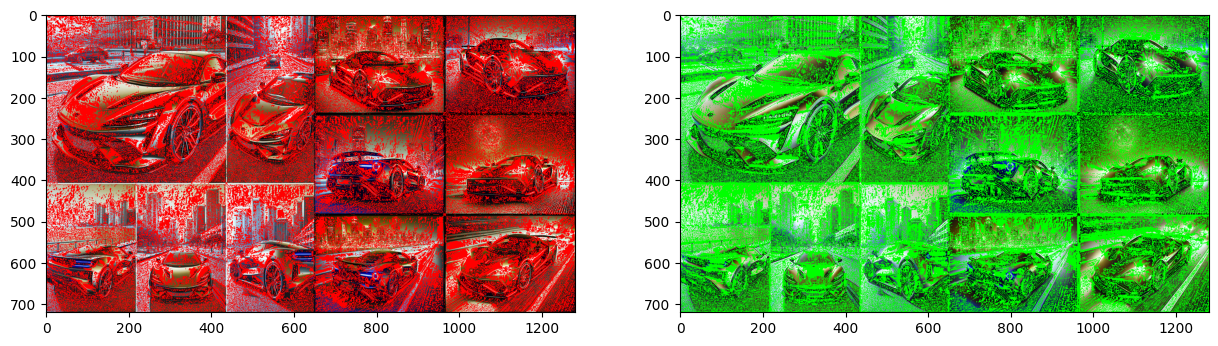

In [ ]:
plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_copy_for_corners, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_copy_for_edges, cmap="gray")

#### En el collage del auto en la ciudad de día y de noche con diferentes ángulos detecta diferentes esquinas y bordes, esta imagen contiene diferentes curvas y líneas un auto deportivo contiene muchas curvas y bordes al igual que en la ciudad moderna donde se ubica con rascacielos. Este método matemática computacional impacta en areas como en el sector de salud para detectar el más pequeño tumor existente.

# 7. Experimento <a class="anchor" id="experimento" ></a>

#### A manera de ánalisis decidimos utilizar el método Harris para explorar el nivel de madurez en frutas, seleccionamos un racimo de bananas en diferentes etapas con diferentes ángulos. En investigaciones científicas avanzadas esta técnica se utiliza para detectar posibles plagas en alimentos.

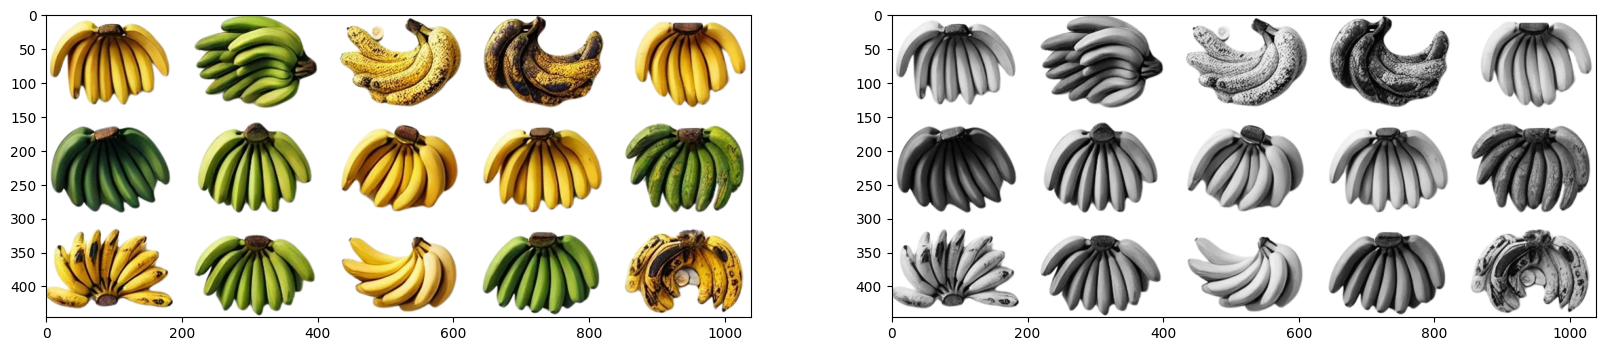

In [ ]:
img2 = cv2.imread('data/bananas.png')
img_color = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
img_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_color)
plt.subplot(1, 2, 2)
plt.imshow(img_gray, cmap="gray")

In [ ]:
#calcula los gradientes en x e y el operador Sobel
def compute_gradients(img_gray):
  I_x = cv2.Sobel(img_gray, cv2.CV_64F, 1, 0, ksize=3)
  I_y = cv2.Sobel(img_gray, cv2.CV_64F, 0, 1, ksize=3)
  return I_x, I_y

#genera un kernel gaussiano
def gaussian_kernel(size, sigma=1):
  k = cv2.getGaussianKernel(size, sigma)
  return k @ k.T

In [ ]:
#calcula la matriz de estructua tensorial suavizada
def compute_structure_tensor(I_x, I_y, ksize=3, sigma=1):
  g_kernel = gaussian_kernel(ksize, sigma)
  Ixx = cv2.filter2D(I_x**2, -1, g_kernel)
  Ixy = cv2.filter2D(I_x*I_y, -1, g_kernel)
  Iyy = cv2.filter2D(I_y**2, -1, g_kernel)
  return Ixx, Ixy, Iyy

#Calcula la respuesta de Harris
def harris_response(Ixx, Iyy, Ixy, k=0.04):
    detA = Ixx * Iyy - Ixy ** 2
    traceA = Ixx + Iyy
    return detA - k * (traceA ** 2)

# Calculate gradients
Ix, Iy = compute_gradients(img_gray)

# Calculate structure tensor
Ixx, Ixy, Iyy = compute_structure_tensor(Ix, Iy)


# Calculate Harris response
harris_response = harris_response(Ixx, Iyy, Ixy)

In [ ]:
img_copy_for_corners = np.copy(img2)
img_copy_for_edges = np.copy(img2)

for rowindex, response in enumerate(harris_response):
    for colindex, r in enumerate(response):
        if r > 0:
            # this is a corner
            img_copy_for_corners[rowindex, colindex] = [255,0,0]
        elif r < 0:
            # this is an edge
            img_copy_for_edges[rowindex, colindex] = [0,255,0]

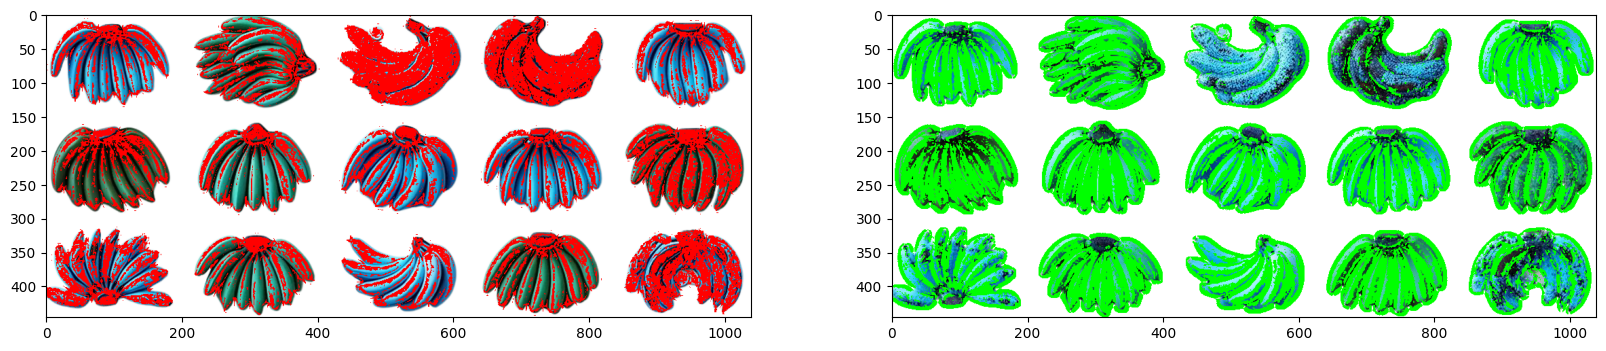

In [ ]:
plt.figure(figsize=(20, 8))
plt.subplot(1, 2, 1)
plt.imshow(img_copy_for_corners, cmap="gray")
plt.subplot(1, 2, 2)
plt.imshow(img_copy_for_edges, cmap="gray")

# Conclusión <a class="anchor" id="conclusión" ></a>

#### A partir de nuestras pruebas con el detector de esquinas de Harris, observamos que su desempeño varía significativamente en función de las condiciones de iluminación y el ángulo de captura de la imagen. En escenas bien iluminadas y con contraste marcado, el detector identifica esquinas con precisión, resaltando bordes definidos y estructuras geométricas. Sin embargo, en condiciones de poca luz o sombras pronunciadas, el rendimiento se ve afectado, mostrando una menor detección o respuestas menos precisas.

#### Asimismo, los cambios en la perspectiva pueden alterar la cantidad y distribución de esquinas detectadas, lo que sugiere que el método es sensible a transformaciones geométricas. Esto refuerza la importancia de ajustar los parámetros del detector (como el umbral de respuesta y el tamaño de la ventana) para optimizar la detección según el contexto de uso.

#### En general, el detector de Harris demuestra ser una herramienta robusta en entornos bien controlados, pero su aplicabilidad en condiciones variables requiere calibración y, en algunos casos, el uso de técnicas complementarias como adaptaciones en la preprocesamiento de la imagen o el empleo de otros detectores en combinación.